# 4NEMO: Diagram generation automated
This script generates Diagrams for Model and Scenario comparisons of the 4NEMO project

In [ ]:
'''
Mathias Todo liste:

Wir sind jetzt durch mit der Diskussion und folgendes ist mir zusätzlich noch aufgefallen (durchgestrichen die bereits erledigten und in „fett“ die neuen).

1.	NEU „Full-load hours generation“ – Das ist etwas Tricky. Wir haben Probleme unsere Modelle zu vergleichen und müssen das daher gegenchecken. Wir reporten diese Full-load hours generation für jede Technologieklasse. Kannst du eine Art „Scatter-Plot“ entwickeln, welche die Full-load hours pro Technologie darstellt? Ich hänge dir ein Beispiel an. 
a.	MODEL_sce – Die y-Achse stellt 0 – 9000h dar, die x-Achse stellt die Unterschiede je nach Region dar. Alle Technologien über eine Legende dargestellt (wie in „Installed capacities“) und die jeweilige Technologie mit einem „Kreuz oder Ähnlichem“ gekennzeichnet. Das jeweils bitte für 2015, 2020, 2035 und 2050 in einem Diagramm (wie bei den pct).
b.	MODEL_sce_red – Hier bitte das Gleiche, aber lediglich „Solar PV“, „WindOn“ und „WindOff“ darstellen. Eventuell ist es möglich die Jahre 2015, 2020, 2035 und 2050 direkt zu integrieren wie in dem angehängten Beispiel. Wenn nicht, dann bitte wie oben für 2015, 2020, 2035 und 2050 in einem Diagram (wie bei den pct).

2.	NEU „Storage cap-p“ (Charge-Discharge-Kapazität, in MW) – Bitte erstelle Grafiken, angelehnt an „Installed capacity abs“ mit PumpStorage_2015, Storage_LT und Storage_ST
3.	NEU „Storage cap-c“ (Reservoir-Kapazität, in MWh) – Wie oben
4.	NEU „Storage stored-energy“ (in MWh) – Wie oben


12.	„Total system cost“ – Hier passiert ein kleiner Fehler. In den Files gibt es drei Spalten: (1) System costs, (2) System fixed costs, (3) System variable costs“. Aktuell werden alle drei Spalten aufaddiert, gebraucht wird aber nur (1) System costs.
13.	NEU „System fixed costs“ – Bitte das gleiche nur für Spalte (2) System fixed costs
14.	NEU „System variable costs“ – Bitte das Gleiche nur für Spalte (3) System variable costs
15.	NEU „System investment costs“ – Bitte rechne folgendes: (1) minus (2) minus (3) = System investment costs. Anschließend bitte plotten.

18.	NEU „DE_sce“ - Kannst du angelehnt an die regional spezifischen Diagramme, eine neue Klasse generieren (regions_models), welche jeweils eine Region, z.B. DE, mit allen Modellen, d.h. EUREGEN/E2M2/DIM/URBS/HECTOR, zeigt? Bitte benenne diese dann REGION_sce, z.B. DE_eu.

'''

In [1]:
# Import modules used
import pandas as pd                 # package for working with dataframes
import matplotlib.pyplot as plt     # pythons main plotting package
import numpy as np                  # main package for math and matrix algebra
import os                           # package related to system properties
import matplotlib.ticker as mtick   # needed to convert axis labels to percent
from collections import defaultdict, OrderedDict  # additional package used for minor 
from pathlib import Path            # package used to create a directory for each and every graph type

## Config: Set Parameters for Graph Generation:

In [63]:
# Set important Configuartion Parameters for Generation:

# Parameters for loading Data:

in_path ='W:/AG-UVKE/Projekte/4NEMO/EU_REGEN_4NEMO/4NEMOv6/run/excel/Patrick/files_variations_easy'   # path of input data (should be xlsx or xls)
out_path= "W:/AG-UVKE/Projekte/4NEMO/EU_REGEN_4NEMO/4NEMOv6/run/excel/Patrick/graphs" # path for graph outputs           
model_selection = ['HECTOR', 'URBS', 'E2M2', 'EUREGEN', 'DIM']                        # which models should be included (has to be list even for only one model)
scenario_selection = ['nation', 'green', 'gas', 'eu']                                 # which scenario should be included (has to be list even if only one scenario)

# Parameters for Processing Data:
sheet_names = ['Emissions by fuel']                                                         # Name of the sheet for which data should be extracted and graphs should be generated
comparison= ['scenarios', 'models']                                                   # Specifies if different'models' or different 'scenarios' for one model are compared or both
sites = ["DE", "FR", "IT", "IEUK", "BELUNL", "DKFINOSE", "ESPT", "ATCH",
         "CZPLSK", "EELTLV", "HRHUSI", "BGELRO"]

# diagrams already implemented so far for: ['Electricity generation', 'Curtailment', 'Installed capacities', 'Total system costs', 'Emissions by fuel']
# diagrams soon to be implemented for: ['Storage']

# Diagram Layout Parameters:
fig_size_single = (15, 6)       # layout for the figures without subplots
fig_size_sub = (16,8)           # layout for figures with subplots


In [4]:
# Select Parameters for Plot style and color scheme:

# Select style:
plt.style.use('ggplot') # see: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html


#  Adding certain color to each energy type:

color_vector =   {'Bio-CCS':   "#c0f723", 
                  'Bioenergy': "#04B404", 
                  'Solar':     "#FACC2E", 
                  'WindOff':   "#01A9DB", 
                  'WindOn':    "#00FFF6", 
                  'Geothermal':"#B18904", 
                  'Hydro':     "#3104B4", 
                  'Nuclear':   "#8B0004", 
                  'Gas':       "#DBA901", 
                  'Gas-CCS':   "#F5DA81", 
                  'Coal':      "#232323", 
                  'Coal-CCS':  "#6E6E6E", 
                  'Lignite':   "#B45F04", 
                  'OilOther':  "#424242",
                  'CO2-emissions-bioenergy': "#c0f723",
                  'CO2-emissions-gas': "#DBA901",
                  'CO2-emissions-coal': "#232323",
                  'CO2-emissions-lignite': "#B45F04",
                  'CO2-emissions-oil/other': "#424242"} 


In [103]:
# subset of years that should be displayed in the pct Diagrams (leave empty for all)

graph_options = {'Emissions by fuel':
                    {'title': 'CO2 Emissions',
                     'ylab':'CO2 Emissions (in MT)' , #y-label of the absolute graph
                     'xlab': 'Year', # x-label of the absolute and pct graphs
                     'percentage_graph': False, #Bolean: should pct graphs be generated
                     'absolute_graph': True, #Bolean: should absolute graphs be generated
                     'years_pct':  ['2015', '2020', '2035', '2050'], # subset of years that should be displayed in the abs Diagrams (leave empty for all)
                     'years_abs':  [] ,
                     'col_drop': [],    # which columns of the sheets should be dropped (leave blank if None)
                     'ticks': [0, 500, 1000, 1500, 2000], # custom ticks for absolute graph (write None if no custom ticks)
                     'y_limit': (-150, 2500), # custom limit for y-axis in absolute graph (write None if no custom limit)
                     'bar_total_marker': True, # adds a diamond arker to the total value of the absolute_graph (used if negative values for emissions)
                     'regions_pct_graph': False, #Bolean: should regional pct graphs be generated
                     'regions_abs_graph': False, #Bolean: should regional absolute graphs be generated
                     'regions_scenarios': True  #Bolean: should regional absolute graphs be generated which show a scenario comparison
            
                    },
                        
                'Installed capacities':
                    {'title': 'Evolution of installed capacities',
                     'ylab': 'Installed capacities (in MW)',
                     'xlab': 'Year',
                     'percentage_graph': True,
                     'absolute_graph': True,
                     'years_pct':  ['2015', '2020', '2035', '2050'],
                     'years_abs':  [] ,
                     'col_drop': [],
                     'ticks': [500000, 1000000, 1500000, 2000000, 2500000 ,3000000, 3500000],
                     'y_limit': (0,3500000) ,
                     'bar_total_marker': False,
                     'regions_pct_graph': False,
                     'regions_abs_graph': False,
                     'regions_scenarios': False 

                    },
                        
                'Curtailment':
                    {'title': 'Curtailment',
                     'ylab': 'Y',
                     'xlab': 'Year' ,
                     'percentage_graph': False,
                     'absolute_graph': True,
                     'years_pct':  ['2015', '2020', '2035', '2050'],
                     'years_abs':  [] ,
                     'col_drop': [],
                     'ticks': None,
                     'y_limit': None ,
                     'bar_total_marker': False,
                     'regions_pct_graph': False,
                     'regions_abs_graph': False,
                     'regions_scenarios': False
            
                    },
                        
                'Electricity generation':
                    {'title': 'Electricity generation',
                     'ylab': 'Electricity generation (in MWh)',
                     'xlab': 'Year',
                     'percentage_graph': False,
                     'absolute_graph': False,
                     'years_pct':  ['2015', '2020', '2035', '2050'],
                     'years_abs':  [] ,
                     'col_drop': [],
                     'ticks': [1000000000, 2000000000, 3000000000, 4000000000, 5000000000, 6000000000],
                     'y_limit': (0, 7000000000),
                     'bar_total_marker': False,
                     'regions_pct_graph': True,
                     'regions_abs_graph': False,
                     'regions_scenarios': False
            
                    },
                        
                'Total system costs':
                    {'title': 'Total System Costs',
                     'ylab': 'Total System Costs (in Mio Euro)',
                     'xlab': 'Year',
                     'percentage_graph': False,
                     'absolute_graph': True,
                     'years_pct':  ['2015', '2020', '2035', '2050'],
                     'years_abs':  [] ,
                     'col_drop': [],
                     'ticks': None,
                     'y_limit': None,
                     'bar_total_marker': False,
                     'regions_pct_graph': False,
                     'regions_abs_graph': False,
                     'regions_scenarios': False    
                    }
                 }

## 1. Load Data Files

In [5]:
# Load Testing data:

def load_data(models, scenarios):
    dfs = {}
    print('Started reading in Data Files')
    for m in models:
        for s in scenarios:
            print(f'Reading in data file: {m}_{s}.xlsx')
            dfs[f'{m}_{s}'] = pd.ExcelFile(f'{in_path}/{m}_{s}.xlsx')

    print('Finished reading in data files')
    return dfs
    
dfs = load_data(model_selection, scenario_selection)

Started reading in Data Files
Reading in data file: HECTOR_nation.xlsx
Reading in data file: HECTOR_green.xlsx
Reading in data file: HECTOR_gas.xlsx
Reading in data file: HECTOR_eu.xlsx
Reading in data file: URBS_nation.xlsx
Reading in data file: URBS_green.xlsx
Reading in data file: URBS_gas.xlsx
Reading in data file: URBS_eu.xlsx
Reading in data file: E2M2_nation.xlsx
Reading in data file: E2M2_green.xlsx
Reading in data file: E2M2_gas.xlsx
Reading in data file: E2M2_eu.xlsx
Reading in data file: EUREGEN_nation.xlsx
Reading in data file: EUREGEN_green.xlsx
Reading in data file: EUREGEN_gas.xlsx
Reading in data file: EUREGEN_eu.xlsx
Reading in data file: DIM_nation.xlsx
Reading in data file: DIM_green.xlsx
Reading in data file: DIM_gas.xlsx
Reading in data file: DIM_eu.xlsx
Finished reading in data files


## 2. Define Functions for Preprocessing

In [7]:
# Functions needed for preprocessing the Data:

def calc_gas(df, sheet):
    '''
    Function that calculates the column sum of all Gas types ['Gas-CCGT', 'Gas-OCGT', 'Gas-ST'].
    Input: - pd.DataFrame
           - sheet name as Gas is only calculated for a subset of sheets which include different gas types
           
    Output: pd.DataFrame
    '''
    if sheet in ['Installed capacities', 'Electricity generation']:
            df['Gas'] = df[['Gas-CCGT', 'Gas-OCGT', 'Gas-ST']].sum(axis=1) 
    else:
        pass
    return df

    
def clean_data(df, sites, years):
    '''
    Function that cleans the data from missing values.
    
    Input: pd.Dataframe
    Output: pd.DataFrame
    '''
    cleaned = df.replace({"Eps": np.nan, " ": np.nan})  #.dropna(how='all', subset=df.columns[2:])
    if len(years) > 0:
        cleaned = cleaned[cleaned['scenario-year'].isin(years)]
    if len(sites) > 0:
        cleaned = cleaned[cleaned['Site'].str.strip().isin(sites)]
    return cleaned


def normalize(df):
    '''
    Function that normalies the Data s.t. each row sums up to 100%
    
    Input: pd.Dataframe
    Output: pd.DataFrame
    '''
    norm = df.div(df.abs().sum(axis=1), axis=0)*100    
    return norm


def merge_n_group(df_dict, grouping):
    '''
    Function that concatenates pd.Dataframes from a Dictionary together. The resulting Dataframe is then grouped
    by a specified x variable. (Required for pct Graphs)
    
    Input: dictionary of pd.DataFrames
    Output: pd.groupbyObject
    '''
    keys = list(df_dict.keys()) # takes keys as additional Index for Dataframe
    df_merged = pd.concat([df_dict[key] for key in keys], keys=keys)
    df_grouped = df_merged.groupby([grouping]) # Group the df by x for plotting the data for each group
    
    return df_grouped


def preprocessing(df_dict, years, sites, comparison, sheet, col_vec= color_vector, drop=[], grouping='scenario-year',
                  norm=False, mg=False, order=True):
    '''
    Main Function for preprocessing. Uses Functions clean_data(), normalize() and merge_n_group(), calc_gas()
    
    Input: - df_dict := dictionary of pd.DataFrames
           - norm := Bolean if Data should be normalized
           - mg := Bolean if Data should be merged and grouped
           
    Output: - dictionary of pd.Dataframe or pd.DataFrames (depending on Diagram)
            - List of ordered colors from a color vector for plotting
    
    '''
    
    pp={}
    for i in df_dict:
        if comparison == 'models':
            key = i.split('_')[0] # Rename dictionary key by either scenario or Model
        elif comparison =='scenarios':
            key = i.split('_')[1]
        else:
            key = i

        c = clean_data(df_dict[i], sites=sites, years=years)
        
        pp[key] = calc_gas(c, sheet)
        
        # order the column according to color_vector:
        if order:
            pp[key] = pp[key][['Site', 'scenario-year'] + [t for t in reversed(list(col_vec.keys())) if t in pp[key].columns]]
        
        if grouping != None:
            pp[key] = pp[key].drop(drop, axis=1).groupby([grouping]).sum()  # drops columns and sums over x variable
        
        if norm:
            pp[key] = normalize(pp[key])
            
    # generate ordered color map from the pre defined color_vector accorrding to the ordering of the preprocessed DataFrame
    e_type = pp[list(pp.keys())[0]].columns
    c = [color_vector[t] for t in e_type if t in color_vector]
            
    if mg:
        pp = merge_n_group(pp, grouping)
    
    
    return pp, c


In [100]:
# Helper functions for regional graphs:


def regional_graphs_abs(dict_df, export_path, sheet, fig_size, sites=[], years=[], 
                        title='Title', x_label='X', y_label='Y', col_vec=color_vector):
    
    folder = f'{export_path}/regions'
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    pp, color = preprocessing(dict_df, years=years, sites=sites, comparison=None, sheet=sheet, 
                                   drop=[], norm=False, mg=False, grouping=None)
 
    for site in sites:
        for model_scenario in pp:
            site_df = pp[model_scenario].loc[pp[model_scenario]['Site'].str.strip() == site].groupby(['scenario-year']).sum()
            bar_abs_region(site_df, folder, title=f'{title} {model_scenario} {site}', 
                           x_label=x_label, y_label=y_label, fig_size=fig_size, cmap=color)
            
          
        
def regional_graphs_pct(dict_df, export_path, sheet, fig_size, model='MODEL_NAME', sites=[], years=[], x_label='X',
                        comparison='scenarios', title='Title'):

    folder = f'{export_path}/regions'
    Path(folder).mkdir(parents=True, exist_ok=True)
    pp, color = preprocessing(dict_df, years=years, sites=sites, comparison=comparison, sheet=sheet, 
                                   drop=[], norm=False, mg=False, grouping=None)
    
    for site in sites:
        pp_temp ={}
        for df in pp:
            pp_temp[df] = pp[df].loc[pp[df]['Site'].str.strip() == site].groupby(['scenario-year']).sum()
            pp_temp[df] = pp_temp[df].div(pp_temp[df].abs().sum(axis=1), axis=0)*100 
            
        pp_temp = merge_n_group(pp_temp, grouping='scenario-year')
        
        barh_pct_per_year(pp_temp, folder, x_label=x_label, y_label='Scenarios', fig_size=fig_size,
                          title = f'{title}_{site}', cmap=color)
     
        
def regional_scenarios_abs(dict_df, export_path, sheet, fig_size, sites=[], years=[], y_label='Y', x_label='X',
                        comparison='scenarios', ticks=None, ylim=None, title='Title', total_marker=False):

    folder = f'{export_path}/regions_scenarios'
    Path(folder).mkdir(parents=True, exist_ok=True)
    
    pp, color = preprocessing(dict_df, years=years, sites=sites, comparison=comparison, sheet=sheet, 
                                   drop=[], norm=False, mg=False, grouping=None)
    
    for site in sites:
        pp_temp ={}
        for df in pp:
            pp_temp[df] = pp[df].loc[pp[df]['Site'].str.strip() == site].groupby(['scenario-year']).sum()
                 
        bar_abs(pp_temp, folder, ticks=ticks, ylim=ylim, x_label=x_label, y_label=y_label, fig_size=fig_size,
                title = f'{title}_{site}', cmap=color, total_marker = total_marker)
        

## 3.  Define Functions for Diagram Generation:

In [96]:
# Function for generating stacked bar charts with two labeled x axis (year + scenario or model)

def bar_abs(dict_df, export_path, ticks=None, ylim=None, title='Some Title', x_label='X', y_label='Y', 
            fig_size=(15,6), cmap=None, legend=True, total_marker=False):
    '''
    Function for plotting a stacked bar chart with absolute comparison of models or scenarios per year
    Input: - dict_df:= preprocessed dictionary of pd.Dataframes  (with norm=False and mg=False as pp Parameters)
           - export_path := path to which figure should be exported
           - title, x_label, y_label := string of Labels and title of the figure
           - fig_size = Touple for figure size
           - cmap := color vector corresponding to categories of stacked bar chart
           
    Output: .png Image with 300 Dpi resolution
    '''
    
    bar_width = 0.65/len(dict_df) #formula for bar width scaling factor

    fig, ax = plt.subplots(1,1, figsize=fig_size)


    for ind, key in enumerate(dict_df):
        dict_df[key].plot(kind='bar', ax=ax, stacked=True, align='center', width=bar_width, color=cmap,
                    position=ind*1.15, edgecolor=None, alpha=1)



    # Handle multiple legend error where there are duplicates in labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(reversed(list(by_label.values())), reversed(list(by_label.keys())), loc='center left', bbox_to_anchor=(1, 0.5), title='Type')
    
    if legend == False:  # condition to remove legend from figure (helps for computation of totals)
        ax.get_legend().remove()


    # Add two labels to x axis:
    df_labels =  list(dict_df.keys()) #  obtain the first set of labels from dictionary keys
    #scenarios = [s.split('_')[1] for s in b_labels]


    # Get position (center of each bar to attach the label)
    pos = []
    for bar in ax.patches:
        pos.append(bar.get_x() + bar.get_width()/2.) # 
    pos = list(OrderedDict.fromkeys(pos))

    ax.set_xticks(pos,minor=True) # changes the ticks to the bar centers
    
    if total_marker:  # adds a diamond marker to total values of stacked bar chart
        row_totals = [dict_df[key].sum(axis=1) for key in dict_df]
        flattened = [val for sublist in row_totals for val in sublist]
        plt.plot(pos, flattened, marker='D', linestyle="", alpha=0.8, color="r")


    # Obtain a list of key labels where each label appears n times where n is the number 
    # of bars corresponding to each model/scenario
    lab = []
    for i in range(len(pos)):
        l = df_labels[i//len(dict_df[df_labels[1]])]
        lab.append(l)
        
        
    # Finally set the tick labels to the axis
    ax.set_xticklabels(lab, ha='right', minor=True)
    ax.tick_params(axis='x', which='major', pad=50, size=0) # set difference between major and minor axis
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=50, fontsize=7.5, weight='bold') # change font, size, color of minor tick axis


    # Define General Properties of the graph:
    cats = max([len(i) for i in dict_df.values()])  # Gets the maximum row length (i.e how many years are included) 
    # (needed for tick label position)

    loc_multiplier = (len(dict_df) - 2) * 0.6 # formula that scales the position of the boxes on the x-axis (ie. the years)    
    plt.xticks(np.array(range(cats)) - loc_multiplier*bar_width, rotation=0, backgroundcolor='silver', weight='bold')
    plt.xlabel(x_label, weight='bold', labelpad=15)
    plt.ylabel(y_label, weight='bold')
    
    # Scaling and tick options:
    ax.autoscale()
    if ylim != None:
        plt.ylim(ylim)
    if ticks !=None:
        plt.yticks(ticks)
        
    plt.title(title, weight='bold', fontsize=20, pad=15)

    # Export the Graph to destined location:
    plt.savefig(f'{export_path}/{title}.png', bbox_inches='tight', dpi=300)
    plt.close()



In [70]:
def bar_abs_region(df, export_path, ticks=None, ylim=None, title='Some Title', x_label='X', y_label='Y', 
                   fig_size=(15,6), cmap=None):
    '''
    Function for plotting the regional graphs in absolute values.
    Input: - pd.DataFrame
           - export_path := path to which figure should be exported
           - title, x_label, y_label := string of Labels and title of the figure
           - fig_size = Touple for figure size
           - cmap := color vector corresponding to categories of stacked bar chart
    
    Output: .png Image with 300 Dpi resolution
    '''

    fig, ax = plt.subplots(figsize=fig_size)
    
    df.plot(kind='bar', ax=ax, align='center', stacked=True, color=cmap, edgecolor=None)   
    
    plt.xlabel(x_label, weight='bold', labelpad=15)
    plt.xticks(rotation=0)
    plt.ylabel(y_label, weight='bold')
    plt.title(title, weight='bold', fontsize=20, pad=15)
    
    # Handle multiple legend error where there are duplicates in labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(reversed(list(by_label.values())), reversed(list(by_label.keys())), loc='center left', bbox_to_anchor=(1, 0.5), title='Type')

    # Scaling and tick options:
    ax.set_ylim(top=ax.get_ylim()[1]*1.1)

    plt.savefig(f'{export_path}/{title}.png', bbox_inches='tight', dpi=300)
    plt.close()     
    

In [11]:
# Function for generating horizontal bar charts

def barh_pct_per_year(data, export_path, title='Some Title', x_label='X', y_label='Y', fig_size=(16,8),
                      cmap=None):
    '''
    Function that plots multiple horizontal bar charts in one figure. These can be grouped by year or
    by category (model, scenario)
    
    Input:  - data:= can be either be a grouped pd.Dataframe (if subplots are generated for each year) or 
              a dictionary of pd.DataFrames (if suplots are to be generated for each model/scenario)
            - export_path := path to which figure should be exported
            - title, x_label, y_label := string of Labels and title of the figure
            - fig_size = Touple for figure size
        
    Output: .png Image with 300 Dpi resolution
    '''
    if type(data) is dict:   # checks which type of subplots should be generated
        keys = list(data.keys())
    else:
        keys = list(data.groups.keys()) # Get keys for subplot titles 
    
    
    y_dim = int(np.sqrt(len(keys)))    # obtain optimum number of subplots in the y dimension
    x_dim =  int(np.ceil(len(keys) / y_dim)) # obtain optimal number of subplots in x dimension

    fig, axes = plt.subplots(y_dim , x_dim, figsize=fig_size)

    for i, ax in enumerate(axes.flat):
        if i <  len(keys):
            
            # Generate Suplots per year or per category
            if type(data) is dict:
                data[keys[i]].plot(kind='barh', stacked=True, color=cmap, ax=ax, legend=None, edgecolor=None)
                
            else:
                group = data.get_group(keys[i]) # generate a subplot per group
                group.index = group.index.droplevel(1) # drop the second index (necessary to obtain ylabels for subplots)
                group.plot(kind='barh', stacked=True, color=cmap, ax=ax, legend=None, edgecolor=None) 
                 
                    
            # Define Suplot properties
            ax.set_title(f'{keys[i]}', bbox=dict(facecolor='lightgrey', edgecolor='none'), pad=10)
            ax.xaxis.set_major_formatter(mtick.PercentFormatter()) # Gives axis in % terms
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.yaxis.set_tick_params(labelsize=10)
            ax.set_xlim(right=105)
            #ax.title._bbox_patch._mutation_aspect = 0.04
            #ax.title.get_bbox_patch().set_boxstyle("square", pad=10.34)

        else:
            break

    # Set General Properties of Figure
    handles, labels = ax.get_legend_handles_labels()
    plt.suptitle(title , weight='bold', fontsize=20)
    fig.legend(handles, labels, loc='lower center', title='Type', fancybox=True, ncol=5)
    fig.text(0.04, 0.5, y_label , va='center', rotation='vertical', fontsize=15)
    

    # Manage Spacing of Suplots:
    left  = 0.11  # the left side of the subplots of the figure
    right = 0.875  # the right side of the subplots of the figure
    bottom = 0.18  # the bottom of the subplots of the figure
    top = 0.85     # the top of the subplots of the figure
    wspace = 0.25   # the amount of width reserved for blank space between subplots
    hspace = 0.3   # the amount of height reserved for white space between subplots
    

    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

    # Export the Graph
    plt.savefig(f'{export_path}/{title}.png', bbox_inches='tight', dpi=300)
    plt.close()


## 4. Automate the Graph Generation depending on defined parameters and loaded files

In [12]:
# Define Two helper Functions which are used in the automation for model and scenario diagrams

def get_model_dict(df_dict):
    '''
    Function generates a dictionary with model names as keys and scenario names as values. It depends on
    which files are loaded.
    
    Input: - dfs := dictionary of loaded Dataframes
    
    Output: dictionary of model names as keys and scenarios as values.
    '''
    splitted = [key.split('_') for key in list(df_dict.keys())]

    model_dict = defaultdict(list)
    for s in splitted:
        model_dict[s[0]].append(s[1])
        
    return model_dict


def get_scenario_dict(df_dict):
    '''
    Function generates a dictionary with scenario names as keys and model names as values. It depends on
    which files are loaded.
    
    Input: - dfs := dictionary of loaded Dataframes
    
    Output: dictionary of scenario names as keys and models as values.
    '''
    splitted = [key.split('_') for key in list(df_dict.keys())]

    scen_dict = defaultdict(list)
    for s in splitted:
        scen_dict[s[1]].append(s[0])
        
    return scen_dict

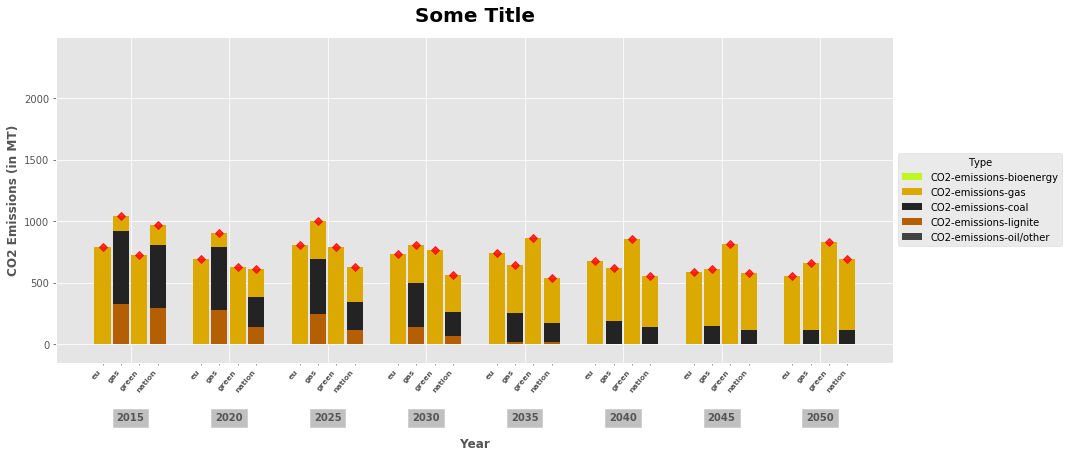

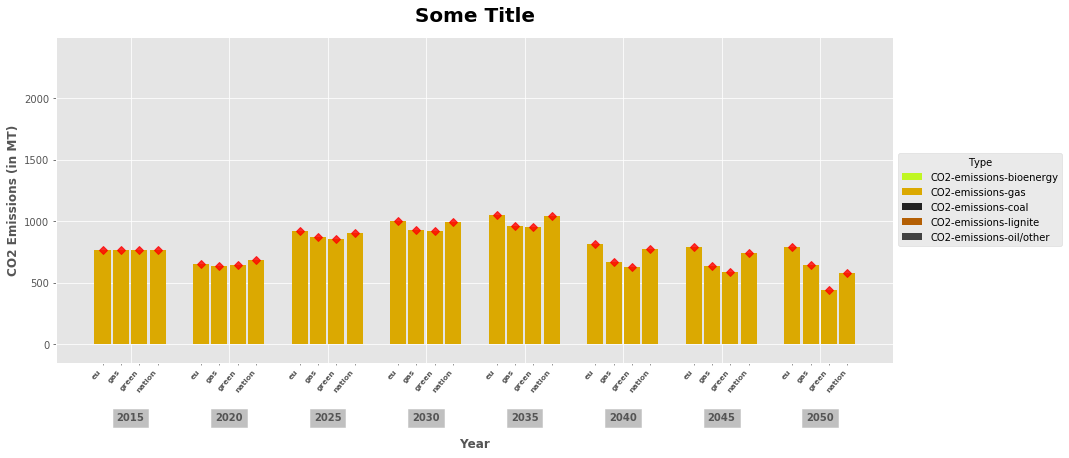

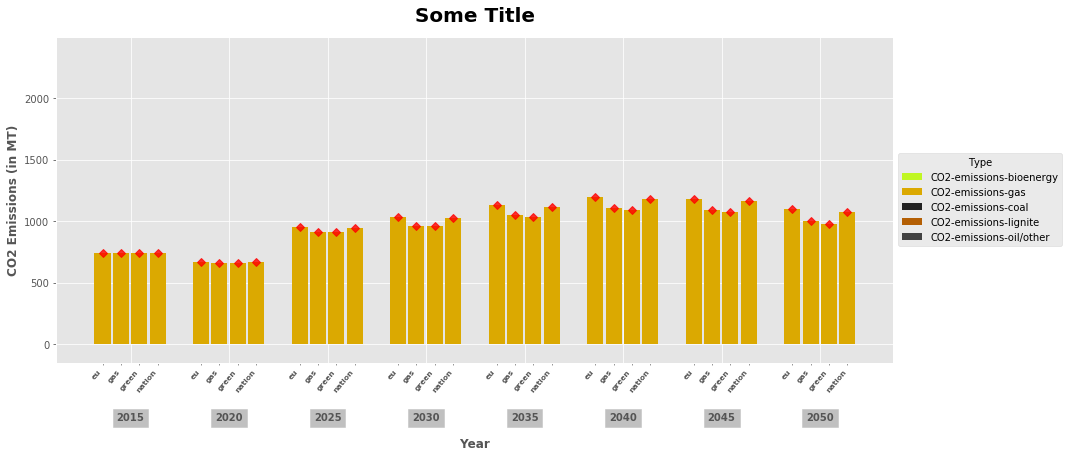

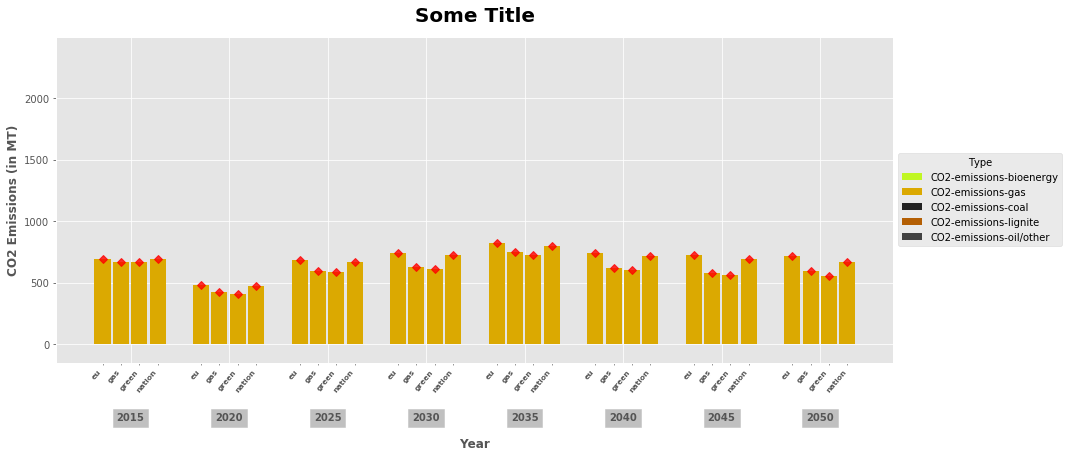

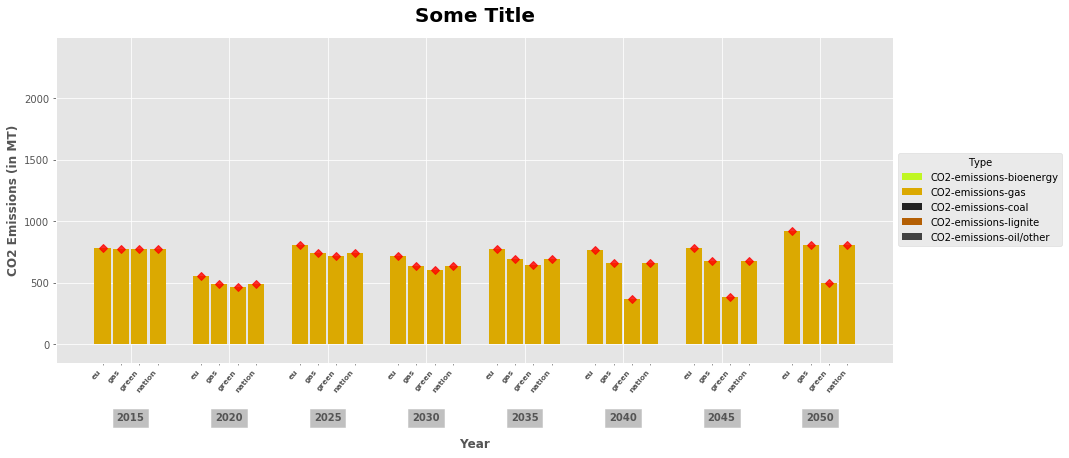

In [95]:
select = {}
for df in dfs:
        select[df] = pd.read_excel(dfs[df], 'Emissions by fuel')
        
            

    
for comp in comparison:
        if comp == 'scenarios':
            for model in model_dict:
                matching = [s for s in select if model in s] #obtain list of scenarios for each model
                subset = {key: select[key] for key in matching} #select a subset dictionary containing data for only one model

                
                pp, color  = preprocessing(subset, years=[], 
                                           sites=sites, comparison=comp, sheet='Emissions by fuel',
                                           norm=False, mg=False, order = True)
                

                bar_abs(pp, '', ticks=graph_options['Emissions by fuel']['ticks'], ylim=graph_options['Emissions by fuel']['y_limit'],
                        x_label=graph_options['Emissions by fuel']['xlab'], y_label=graph_options['Emissions by fuel']['ylab'], 
                        fig_size=fig_size_single, cmap=color, legend=True, total_marker=True)

In [102]:
def visualize(dfs, sheet, out_path, graph_options, model_dict, scenario_dict, fig_size_single, fig_size_sub,
              sites, comparison):
    '''
    Fuction for  visualizing results from the 4NEM= Project
    Inputs: - dfs := dictionary of Dataframes obtained from load_data
            - sheet := sheet for which the graphs should be generated
            - out_path := path to folder where graphs should be placed (String)
            - graph_options := options for graph generation for the sheet (Nested Dataframe)
            - model_dict, scenario_dict := helper dictionaries obtained by get_model_dict() and get_scenario_dict
    '''
    print('Started Processing sheet:', sheet)
    
    
    show_legend = True # omit legend of graphs if False (only required for Totals)
    ordered = True     # order dictionary according to color_vector (should be set to false if columns not in color vector)
    
    if sheet =='Total system costs':
        show_legend = False
        ordered = False
    
    title = graph_options[f'{sheet}']['title']
    ylab = graph_options[f'{sheet}']['ylab']
    xlab = graph_options[f'{sheet}']['xlab']
    years_abs = graph_options[f'{sheet}']['years_abs']
    years_pct = graph_options[f'{sheet}']['years_pct']
    ticks = graph_options[f'{sheet}']['ticks']
    y_limit = graph_options[f'{sheet}']['y_limit']
    total_marker = graph_options[f'{sheet}']['bar_total_marker']
    
    select= {}
    for df in dfs:
        select[df] = pd.read_excel(dfs[df], sheet)
       
     
    folder_abs = f'{out_path}/{sheet} abs'
    Path(folder_abs).mkdir(parents=True, exist_ok=True)
    
    # Create folder for pct graphs if not yet exists:
    folder_pct = f'{out_path}/{sheet} pct'
    Path(folder_pct).mkdir(parents=True, exist_ok=True) 
    
    # generate regional absolute diagrams for model scenarios:
    if graph_options[f'{sheet}']['regions_abs_graph']:
        regional_graphs_abs(select, folder_abs, sites=sites, fig_size=fig_size_single, years=[], sheet=sheet, 
                    title=title, x_label=xlab, y_label=ylab)
      
    for comp in comparison:
        if comp == 'scenarios':
            for model in model_dict:
                matching = [s for s in select if model in s] #obtain list of scenarios for each model
                subset = {key: select[key] for key in matching} #select a subset dictionary containing data for only one model
                
                if graph_options[f'{sheet}']['absolute_graph']:
                    pp, color  = preprocessing(subset, years=years_abs, 
                                               sites=sites, comparison=comp, sheet=sheet,
                                               norm=False, mg=False, order = ordered)
                    
                    if sheet == 'Total system costs':
                        color = 'dimgrey'
                        show_legend = False
                        ordered = False
                        
                        for key in pp:
                            pp[key] = pp[key].sum(axis=1)
                    
                    
                    bar_abs(pp, folder_abs, ticks=ticks, ylim=y_limit, x_label=xlab, y_label=ylab, 
                            fig_size=fig_size_single,
                            title = f'{title} {model}', cmap=color, legend=show_legend, total_marker = total_marker)
                    
                
                if graph_options[f'{sheet}']['regions_scenarios']:
                    regional_scenarios_abs(subset, folder_abs, sheet=sheet, fig_size=fig_size_single, sites=sites, years=[], y_label=f'{ylab}', x_label=f'{xlab}',
                        comparison=comp, title=f'{title} {model}', total_marker = total_marker)
                
                if graph_options[f'{sheet}']['percentage_graph']:
                    pp2, color  = preprocessing(subset, years=years_pct, sites=sites, comparison=comp, sheet=sheet, 
                                       norm=True, mg=True)
                    
                
                    barh_pct_per_year(pp2, folder_pct, x_label=f'{xlab}', y_label='Scenarios', fig_size=fig_size_sub,
                                     title = f'{title} pct {model}', cmap=color)
                    
                if graph_options[f'{sheet}']['regions_pct_graph']:
                    regional_graphs_pct(subset, folder_pct, model=model, sites=sites, fig_size=fig_size_sub, years=years_pct, x_label=f'{xlab}',
                                        comparison=comp, sheet=sheet, title=f'{title} pct {model}')

        elif comp == 'models':
            for scenario in scenario_dict:
                matching = [s for s in select if f'_{scenario}' in s] #obtain list of models for each scenario
                subset = {key: select[key] for key in matching} #select a subset dictionary containing data for only one scenario
                
                if graph_options[f'{sheet}']['absolute_graph']:
                    pp, color = preprocessing(subset, years=years_abs, sites=sites, comparison=comp, sheet=sheet, 
                                       norm=False, mg=False, order = ordered)
                    
                    if sheet == 'Total system costs':
                        color = 'dimgrey'
                        
                        for key in pp:
                            pp[key] = pp[key].sum(axis=1)
                                      
                    bar_abs(pp, folder_abs, ticks=ticks, ylim=y_limit,  x_label=f'{xlab}', y_label=f'{ylab}',
                            fig_size=fig_size_single, title = f'{title} {scenario}', 
                            cmap=color, legend=show_legend, total_marker = total_marker)
                
                
                if graph_options[f'{sheet}']['percentage_graph']:
                    pp2, color  = preprocessing(subset, years=years_pct, sites=sites, comparison=comp, sheet=sheet, 
                                       norm=True, mg=True)
                
                    barh_pct_per_year(pp2, folder_pct, x_label=f'{xlab}', y_label='Models', fig_size=fig_size_sub,
                                     title = f'{title} pct {scenario}', cmap=color)
                    
    return None


In [104]:
model_dict = get_model_dict(dfs)
scenario_dict = get_scenario_dict(dfs)

for sheet in sheet_names:
        visualize(dfs=dfs, sheet=sheet, out_path = out_path, fig_size_single = fig_size_single,
                  fig_size_sub= fig_size_sub, model_dict=model_dict, scenario_dict=scenario_dict,
                  sites= sites, comparison=comparison, graph_options = graph_options)

Started Processing sheet: Emissions by fuel


In [101]:

model_dict = get_model_dict(dfs)
scenario_dict = get_scenario_dict(dfs)

for sheet in sheet_names:
    print('Started Processing sheet:', sheet)
    
    row_totals = False # Extra processing step to obtain total values over all columns
    show_legend = True # omit legend of graphs if False (only required for Totals)
    ordered = True     # order dictionary according to color_vector (should be set to false if columns not in color vector)
    
    select= {}
    for df in dfs:
        select[df] = pd.read_excel(dfs[df], sheet)
    
    
    if sheet == 'Emissions by fuel':
        title = 'CO2 Emissions'
        ylab = 'CO2 Emissions (in MT)'
        xlab = 'Year'
        percentage_diag = True
        years_pct = ['2015', '2020', '2035', '2050']   # subset of years that should be displayed in the pct Diagrams (leave empty for all)
        years_abs = []                                 # subset of years that should be displayed in the abs Diagrams (leave empty for all)
        col_drop = []                                  # which columns of the sheets should be dropped (leave blank if None)
        sites = sites                                  # subset of sites that should be displayed in the Graph (leave empty for all)
        ticks = [0, 500, 1000, 1500, 2000]
        y_limit = (-150, 2500)
        regions_pct=False
        regions_abs=False
        regions_scenarios = False
        
    elif sheet == 'Installed capacities':
        title = 'Evolution of installed capacities'
        ylab = 'Installed capacities (in MW)'
        xlab = 'Year'
        percentage_diag = True
        col_drop = []
        years_pct = ['2015', '2020', '2035', '2050']
        years_abs = []
        sites = sites                                   # subset of sites that should be displayed in the Graph (leave empty for all
        ticks = [500000, 1000000, 1500000, 2000000, 2500000 ,3000000, 3500000]
        y_limit = (0,3500000)
        regions_pct=False
        regions_abs=False
        regions_scenarios = False
        
    elif sheet == 'Curtailment':
        title = 'Curtailment'
        ylab = 'Y'
        xlab = 'Year'
        percentage_diag = False
        col_drop = []
        years_pct = []
        years_abs = []
        sites = sites                                   # subset of sites that should be displayed in the Graph (leave empty for all
        ticks = None
        y_limit = None
        regions_pct=False
        regions_abs=False
        regions_scenarios = False
        
        
    elif sheet == 'Electricity generation':
        title = 'Electricity generation'
        ylab = 'Electricity generation (in MWh)'
        xlab = 'Year'
        percentage_diag = True
        col_drop = []
        years_pct = ['2015', '2020', '2035', '2050'] 
        years_abs = []
        sites = sites                                   # subset of sites that should be displayed in the Graph (leave empty for all
        ticks = [1000000000, 2000000000, 3000000000, 4000000000, 5000000000, 6000000000]
        y_limit = (0, 6500000000)
        regions_pct=False
        regions_abs=False
        regions_scenarios = False
        
    elif sheet == 'Total system costs':
        title = 'Total System Costs'
        ylab = 'Total System Costs (in Mio Euro)'
        xlab = 'Year'
        percentage_diag = False
        col_drop = []
        years_pct = [] 
        years_abs = []
        sites = sites            # subset of sites that should be displayed in the Graph (leave empty for all
        ticks = None
        y_limit = None
        regions_pct=False
        regions_abs=False
        regions_scenarios = False
        
        # Extra parameters:
        row_totals = True
        show_legend = False
        ordered = False
        c = 'dimgrey'
        
        
    else:
        print('Please select a sheet for processing')
        break
        
    # Create folder for abs graphs if not yet exists:
    folder_abs = f'{out_path}/{sheet} abs'
    Path(folder_abs).mkdir(parents=True, exist_ok=True)
    
    # Create folder for pct graphs if not yet exists:
    if percentage_diag:
        folder_pct = f'{out_path}/{sheet} pct'
        Path(folder_pct).mkdir(parents=True, exist_ok=True) 
    
    # generate regional absolute diagrams for model scenarios:
    if regions_abs:
        regional_graphs_abs(select, folder_abs, sites=sites, years=[], sheet=sheet, 
                    title=title, x_label=xlab, y_label=ylab)
               
    for comp in comparison:
        if comp == 'scenarios':
            for model in model_dict:
                matching = [s for s in select if model in s] #obtain list of scenarios for each model
                subset = {key: select[key] for key in matching} #select a subset dictionary containing data for only one model
                pp, color  = preprocessing(subset, years=years_abs, sites=sites, comparison=comp, sheet=sheet, drop=col_drop, 
                                   norm=False, mg=False, order = ordered)
                
                if row_totals:
                    color = 'dimgrey'
                    for key in pp:
                        pp[key] = pp[key].sum(axis=1)
                
                
                bar_abs(pp, folder_abs, ticks=ticks, ylim=y_limit, x_label=f'{xlab}', y_label=f'{ylab}', fig_size=fig_size_single,
                       title = f'{title} {model}', cmap=color, legend=show_legend)
                
                if regions_scenarios:
                    regional_scenarios_abs(subset, folder_abs, sheet=sheet, sites=sites, years=[], y_label=f'{ylab}', x_label=f'{xlab}',
                        comparison=comp, title=f'{title} {model}')
                
                if percentage_diag:
                    pp2, color  = preprocessing(subset, years=years_pct, sites=sites, comparison=comp, sheet=sheet, drop=col_drop, 
                                       norm=True, mg=True)
                    
                
                    barh_pct_per_year(pp2, folder_pct, x_label=f'{xlab}', y_label='Scenarios', fig_size=fig_size_sub,
                                     title = f'{title} pct {model}', cmap=color)
                    
                if regions_pct:
                    regional_graphs_pct(subset, folder_pct, model=model, sites=sites, years=years_pct, x_label=f'{xlab}',
                                        comparison=comp, sheet=sheet, title=f'{title} pct {model}')

        elif comp == 'models':
            for scenario in scenario_dict:
                matching = [s for s in select if f'_{scenario}' in s] #obtain list of models for each scenario
                subset = {key: select[key] for key in matching} #select a subset dictionary containing data for only one scenario
                pp, color = preprocessing(subset, years=years_abs, sites=sites, comparison=comp, sheet=sheet, drop=col_drop, 
                                   norm=False, mg=False, order = ordered)
                  
                if row_totals:
                    color = 'dimgrey'
                    for key in pp:
                        pp[key] = pp[key].sum(axis=1)
                        
                                  
                bar_abs(pp, folder_abs, ticks=ticks, ylim=y_limit,  x_label=f'{xlab}', y_label=f'{ylab}', fig_size=fig_size_single,
                       title = f'{title} {scenario}', cmap=color, legend=show_legend)
                
                if percentage_diag:
                    pp2, color  = preprocessing(subset, years=years_pct, sites=sites, comparison=comp, sheet=sheet, drop=col_drop, 
                                       norm=True, mg=True)
                
                    
                    barh_pct_per_year(pp2, folder_pct, x_label=f'{xlab}', y_label='Models', fig_size=fig_size_sub,
                                     title = f'{title} pct {scenario}', cmap=color)
    
    
print('Finished generating Diagrams')

Started Processing sheet: Emissions by fuel
Finished generating Diagrams


## 5. Testing area to implement new diagrams or add diagrams for new sheets